In [5]:
import sys, os
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt

from units import *
from lensing_sim import LensingSim

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Fixed parameters

In [26]:
# Grid size
n_x, n_y = 52, 52
x_lims, y_lims = [-2, 2], [-2, 2]

# Host parameters
hst_param_dict = {'profile':'sis', 'theta_x':0.1, 'theta_y':-0.15, 'theta_E':1.}

# Observational parameters
observation_dict = {'nx':n_x, 'ny':n_y, 'xlims':x_lims, 'ylims':y_lims, 'exposure':(1/1.8e-19)*erg**-1*Centimeter**2*Angstrom*1000*Sec, 'A_iso':2e-7*erg/Centimeter**2/Sec/Angstrom/(radtoasc)**2}
global_dict = {'z_s':1.0, 'z_l':0.2}

# Source parameters
src_param_dict = {'profile':'sersic', 'I_gal':1e-17*erg/Centimeter**2/Sec/Angstrom,'theta_e_gal':0.5,'n_srsc':4}

## Model parameters

In [32]:
nu = 5.3

# "z" parameters
n = np.random.poisson(nu) # Number of subhalos
x_coords = np.random.uniform(low=x_lims[0], high=x_lims[1], size=n) # Subhalo coordinates
y_coords = np.random.uniform(low=y_lims[0], high=y_lims[1], size=n)

## Generate image

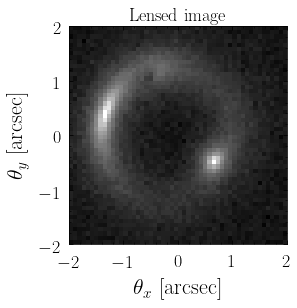

In [29]:
lens_list = [hst_param_dict]

# Substructure parameters
for isub in range(n):
    sub_param_dict = {'profile':'sis', 'theta_x':x_coords[isub], 'theta_y':y_coords[isub], 'theta_E':0.1}
    lens_list.append(sub_param_dict)

# Generate lensed image
LSI = LensingSim(lens_list, [src_param_dict], global_dict, observation_dict)
i_tot = np.random.poisson((LSI.lensed_image()).numpy())

plt.imshow(np.log10(i_tot), vmax=3.5, cmap = 'gist_gray', extent=LSI.xlims+LSI.ylims, origin="lower")
plt.xlabel("$\\theta_x$ [arcsec]");
plt.ylabel("$\\theta_y$ [arcsec]");
plt.title('Lensed image');